# Training CNN Model Cats vs Dogs
Kode berikut merupakan kode untuk practice pengetahuan mengenai Convolutional Neural Network dengan menggunakan dataset Cats vs Dogs. Dataset tersebut terdiri dari 12501 gambar Kucing dan 12501 gambar Anjing. Langkah yang akan dilakukan adalah :


1. Import Package
2. Download data set
3. Membuat Direktori untuk memisahkan gambar menjadi training dan validation
4. Memisahkan dan memindahkan gambar untuk menjadi training dan validation
5. Normalisasi gambar dan merubah ukuran gambar menjadi 150*150
6. Mendefinisikan Model beserta Layer yang akan digunakan
7. Training Model
8. Predicting



## Import Package

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

## Download Dataset
Blok kode tersebut akan melakukan download dataset dan menyimpannya dalam directory /tmp. Setelah dataset terdownload, dataset tersebut dilakukan unzip dan menyimpan nya dalam folder /tmp/PetImages/Cat dan /tmp/PetImages/Dog

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-03-26 06:30:04--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.128.110, 2600:1408:8c00:596::e59, 2600:1408:8c00:5a9::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.220.128.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   212MB/s    in 3.8s    

2021-03-26 06:30:07 (206 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


## Membuat Direktori Baru
Kode tersebut digunakan untuk membuat direktori baru bernama /tmp/cats-v-dogs beserta subdirektori ../training dan ../testing

In [ ]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    print(OSError)

<class 'OSError'>


## Memisahkan dan Memindahkan Gambar
Kode tersebut digunakan untuk memisahkan sekumpulan dataset menjadi training dan testing data dengan rasio 0.9 untuk training. Pemilihan training dilakukan dengan random. Beberapa kode yang digunakan adalah :

```
os.listdir(DIRECTORY)
os.path.getsize(PATH)
copyfile(source, destination)
random.sample(list, len(list))
```
Pada fungsi split_data juga dilakukan preprocessing untuk mengecualikan file yang corrupt
 

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  dataset = []

  for item in os.listdir(SOURCE):
    if(os.path.getsize(SOURCE + item) > 0):
      dataset.append(item)

  length_train_data = int(len(dataset) * SPLIT_SIZE)
  length_test_data = int(len(dataset) - length_train_data)

  train_data = random.sample(dataset, length_train_data)
  test_data = []
  for item in dataset:
    if item not in train_data:
      test_data.append(item)
  
  for item in train_data:
    source = SOURCE + item
    destination = TRAINING + item
    copyfile(source, destination)

  for item in test_data:
    source = SOURCE + item
    destination = TESTING + item
    copyfile(source, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


## Normalisasi gambar 
Pada kode tersebut dilakukan normalisasi dengan cara rescaling agar memiliki pixel warna yang sama yaitu 0-255, serta memiliki ukuran gambar yang sama yaitu 150*150. class_mode yang digunakan adalah binary, karena data hanya tergolong dalam 2 kelas yang berbeda. 
Normalisasi menggunakan package ImageDataGenerator* , dan *flow_from_directory*

In [ ]:
TRAINING_DIR ='/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=10, 
    target_size=(150, 150),
    class_mode='binary'
)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=10, 
    target_size=(150, 150),
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Mendefinisikan Model
Pada kode tersebut dilakukan definisi model beserta layer dalam model yang akan digunakan, yakni terdiri dari 3 lapis Convolutional Neural Network.

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

## Training Model
Pada training model tersebut diharapkan model dapat memberikan akurasi diatas 95% dalam training data, dan 90% dalam validating data

In [ ]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
1189/2250 [==============>...............] - ETA: 34s - loss: 0.7558 - accuracy: 0.6152

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2250/2250 [==============================] - 114s 36ms/step - loss: 0.6771 - accuracy: 0.6534 - val_loss: 0.4853 - val_accuracy: 0.7788
Epoch 2/15
2250/2250 [==============================] - 81s 36ms/step - loss: 0.4659 - accuracy: 0.7907 - val_loss: 0.4422 - val_accuracy: 0.8128
Epoch 3/15
2250/2250 [==============================] - 79s 35ms/step - loss: 0.4349 - accuracy: 0.8095 - val_loss: 0.4548 - val_accuracy: 0.8160
Epoch 4/15
2250/2250 [==============================] - 79s 35ms/step - loss: 0.4263 - accuracy: 0.8186 - val_loss: 0.4732 - val_accuracy: 0.8136
Epoch 5/15
2250/2250 [==============================] - 79s 35ms/step - loss: 0.3986 - accuracy: 0.8308 - val_loss: 0.4342 - val_accuracy: 0.8216
Epoch 6/15
2250/2250 [==============================] - 79s 35ms/step - loss: 0.3960 - accuracy: 0.8340 - val_loss: 0.4137 - val_accuracy: 0.8256
Epoch 7/15
2250/2250 [==============================] - 78s 35ms/step - loss: 0.3763 - accuracy: 0.8428 - val_loss: 0.4119 - val_accur

## Plotting Akurasi
Pada kote tersebut dilakukan visualisasi dari tingkat akurasi dan loss dari epoch yang telah dilakukan pada training model

Text(0.5, 1.0, 'Training and validation loss')

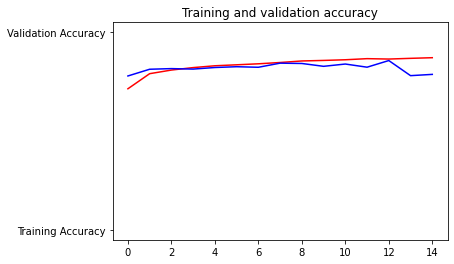

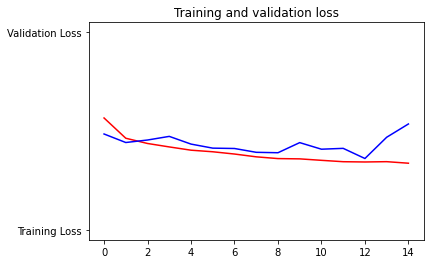

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

"""
Mengambil data akurasi dan loss dari hasil model training
"""

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

"""
Plot akurasi training dan validasi setiap epoch
"""

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

"""
Plot loss training dan validasi setiap epoch
"""
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

## Predicting
Pada kode tersebut dilakukan prediksi dari gambar yang dapat kita pilih sendiri, dan akan menghasilkan keputusan apakah gambar termasuk Anjing atau Kucing

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat-300572_640.jpg to cat-300572_640 (1).jpg
Saving cat-2068462_640.jpg to cat-2068462_640 (1).jpg
Saving cat-2143332_640.jpg to cat-2143332_640.jpg
Saving maltese-1123016_1920.jpg to maltese-1123016_1920.jpg
Saving pug-690566_1280.jpg to pug-690566_1280.jpg
[0.]
cat-300572_640.jpg is a cat
[1.]
cat-2068462_640.jpg is a dog
[1.]
cat-2143332_640.jpg is a dog
[0.]
maltese-1123016_1920.jpg is a cat
[1.]
pug-690566_1280.jpg is a dog
